In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import missingno as miss
import datetime as date
import keras_tuner

In [3]:
rain=pd.read_csv("D:\wallpapers and photos\paper\Rainfall_ctg2.csv")

In [4]:
rain

,year,month,RS,ST
0,1990,1,0.000000,0
1,1990,2,31.269622,39
2,1990,3,89.408551,53
3,1990,4,129.517354,250
4,1990,5,231.539441,205
...,...,...,...,...
355,2019,8,687.318489,466
356,2019,9,308.700764,365
357,2019,10,148.541027,123
358,2019,11,107.030422,83


<Axes: >

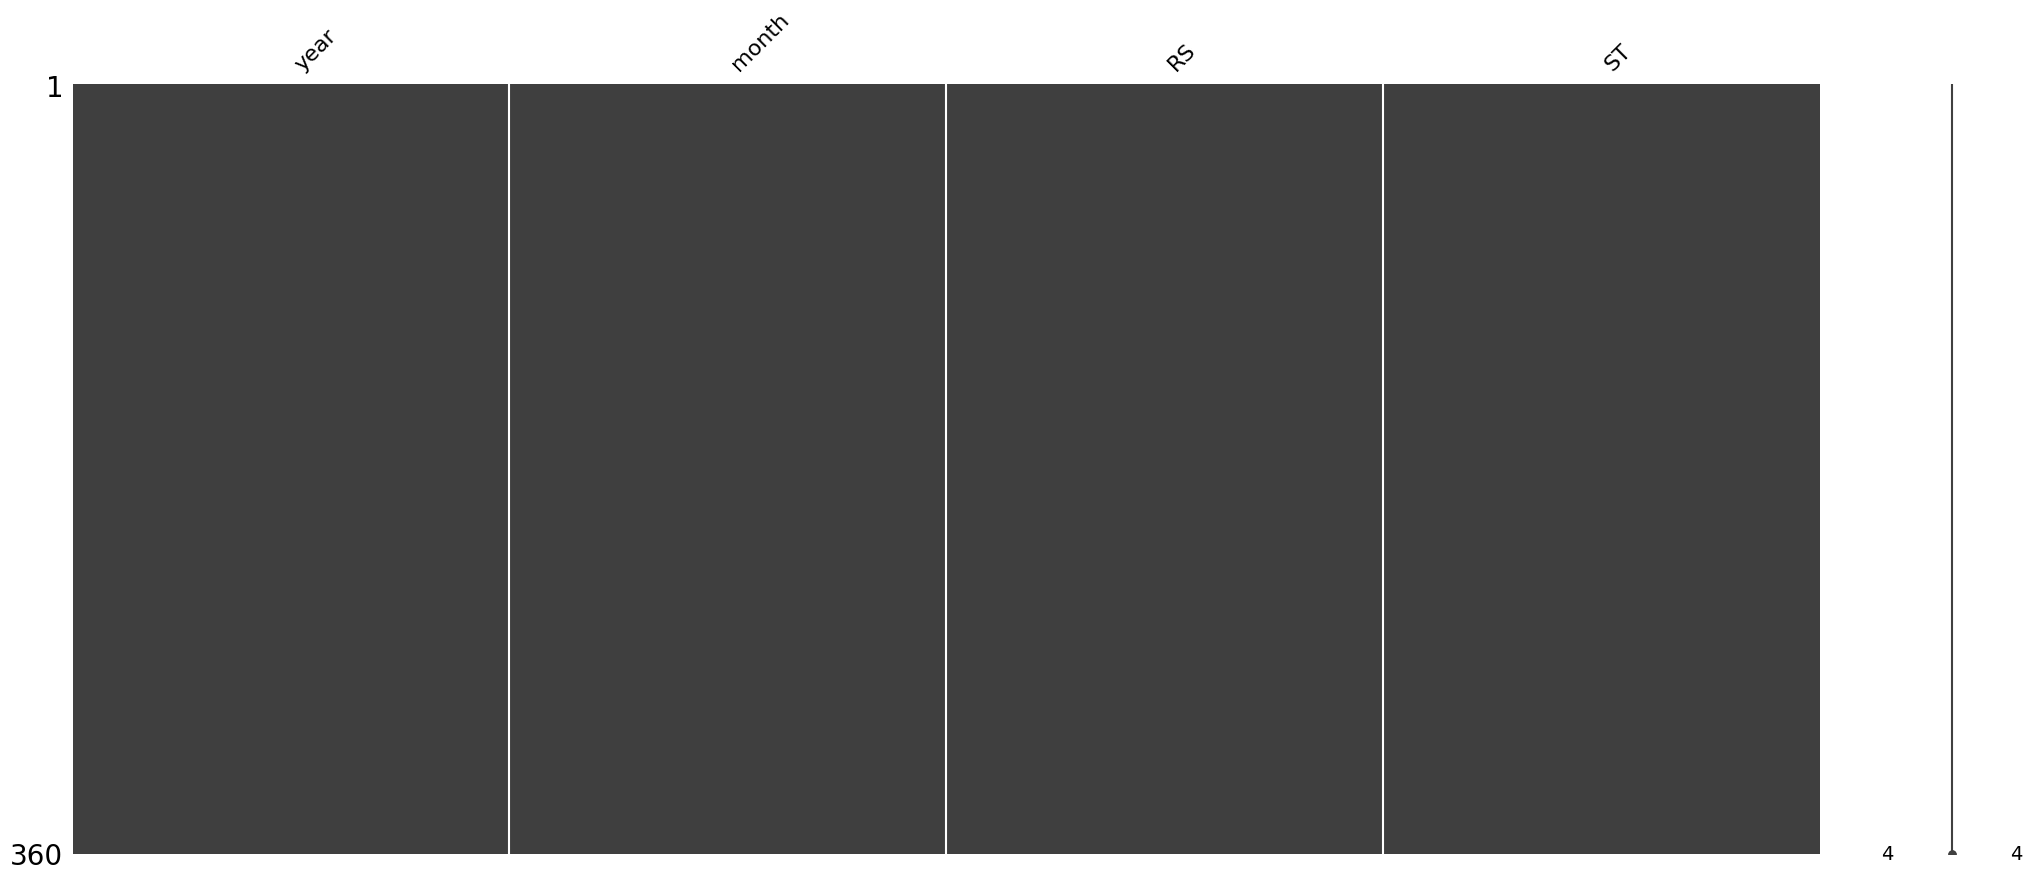

In [5]:
miss.matrix(rain)

In [6]:
rain["date"]=pd.to_datetime(rain[["year","month"]].assign(day=1))

In [7]:
rain=rain[["date","RS","ST"]]

In [8]:
rain

,date,RS,ST
0,1990-01-01,0.000000,0
1,1990-02-01,31.269622,39
2,1990-03-01,89.408551,53
3,1990-04-01,129.517354,250
4,1990-05-01,231.539441,205
...,...,...,...
355,2019-08-01,687.318489,466
356,2019-09-01,308.700764,365
357,2019-10-01,148.541027,123
358,2019-11-01,107.030422,83


In [9]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    360 non-null    datetime64[ns]
 1   RS      360 non-null    float64       
 2   ST      360 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 8.6 KB


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
%matplotlib inline

### perform exponential smoothing holt winters method

In [11]:
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler
scale=SklearnTransformerWrapper(transformer=StandardScaler(),variables=["RS","ST"])
rain=scale.fit_transform(rain)
rain

,date,RS,ST
0,1990-01-01,-0.957577,-0.826823
1,1990-02-01,-0.830189,-0.695896
2,1990-03-01,-0.593339,-0.648897
3,1990-04-01,-0.429941,0.012449
4,1990-05-01,-0.014318,-0.138620
...,...,...,...
355,2019-08-01,1.842461,0.737580
356,2019-09-01,0.300026,0.398514
357,2019-10-01,-0.352442,-0.413901
358,2019-11-01,-0.521550,-0.548185


<Axes: xlabel='date', ylabel='ST'>

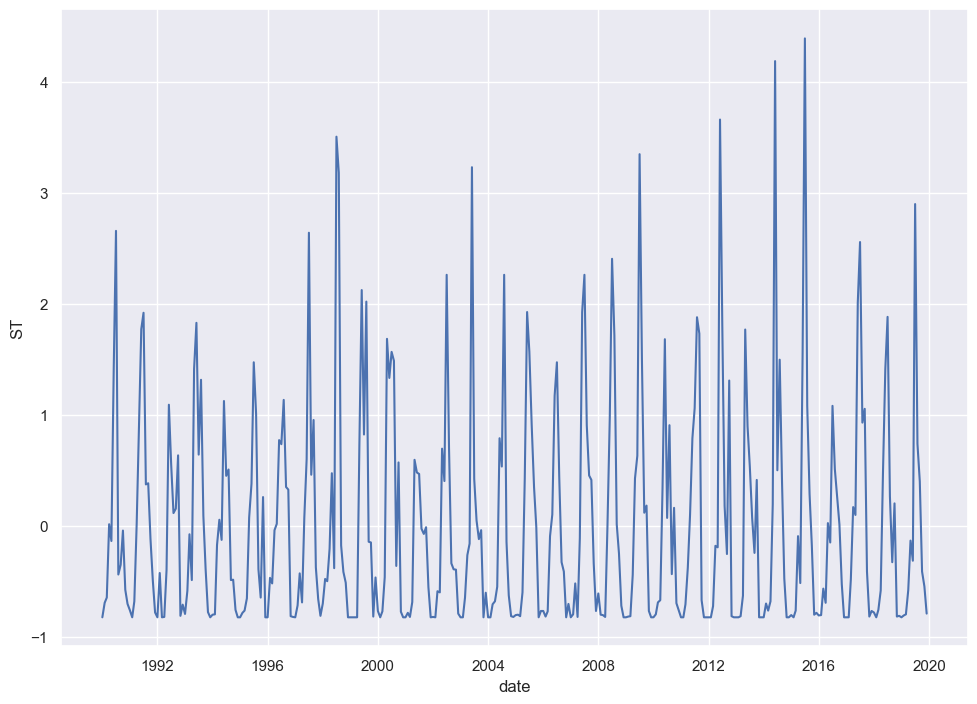

In [12]:
sns.lineplot(x="date",y="ST",data=rain)

<Axes: xlabel='date', ylabel='RS'>

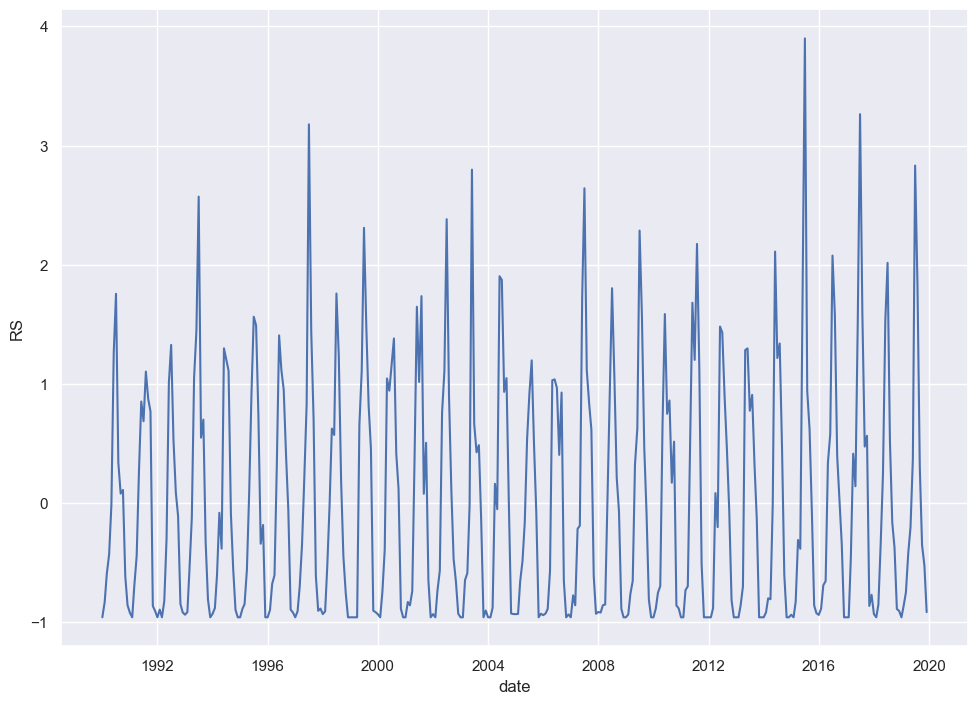

In [13]:
sns.lineplot(x="date",y="RS",data=rain)

<Axes: >

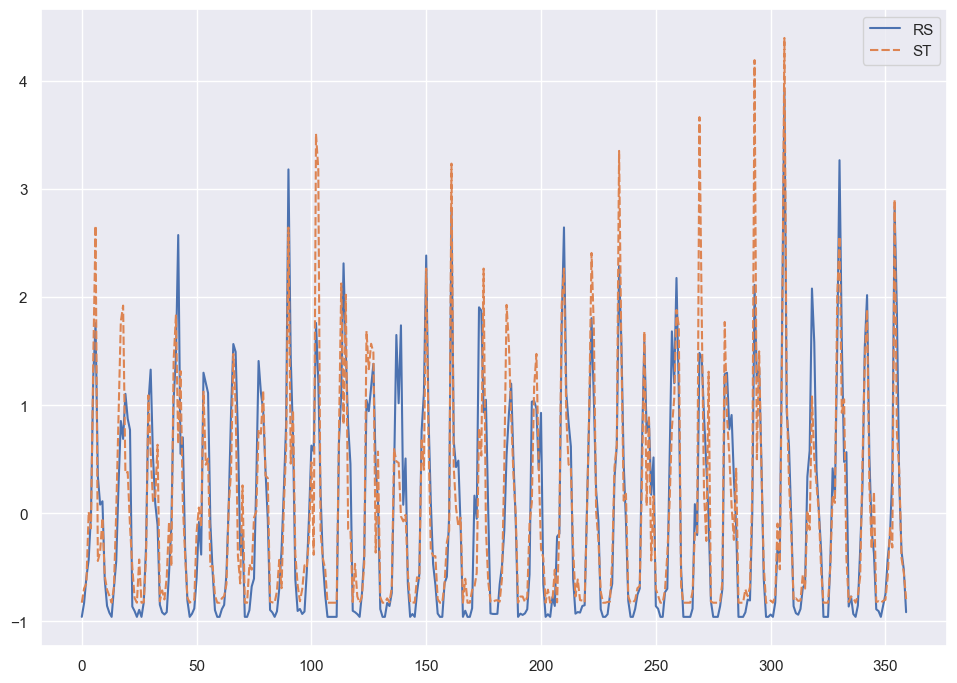

In [14]:
sns.lineplot(data=rain)

In [15]:
train_set, test_set= np.split(rain, [int(.6 *len(rain))])

C:\Users\Lenovo\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [16]:
train_set.shape,test_set.shape

((216, 3), (144, 3))

In [17]:
train_set, val_set= np.split(train_set, [int(.8 *len(train_set))])

In [18]:
train_set.shape,test_set.shape,val_set.shape

((172, 3), (144, 3), (44, 3))

In [19]:
x_train=train_set.drop(["date","ST"],axis=1)
y_train=train_set["ST"]

In [20]:
x_test=test_set.drop(["date","ST"],axis=1)
y_test=test_set["ST"]

In [21]:
x_val=val_set.drop(["date","ST"],axis=1)
y_val=val_set["ST"]

In [22]:
x_train.shape,y_train.shape

((172, 1), (172,))

In [23]:
x_test.shape,y_test.shape

((144, 1), (144,))

In [24]:
x_val.shape,y_val.shape

((44, 1), (44,))

In [25]:
tf.random.set_seed(1234)
sampling_rate = 3
sequence_length =12 
#delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
train_dataset=keras.utils.timeseries_dataset_from_array(data=x_train,targets=y_train,sampling_rate=sampling_rate,sequence_length=sequence_length,shuffle=True,batch_size=batch_size)
test_dataset=keras.utils.timeseries_dataset_from_array(data=x_test,targets=y_test,sampling_rate=sampling_rate,sequence_length=sequence_length,shuffle=True,batch_size=batch_size)
val_dataset=keras.utils.timeseries_dataset_from_array(data=x_val,targets=y_val,sampling_rate=sampling_rate,sequence_length=sequence_length,shuffle=True,batch_size=batch_size)

In [26]:
from keras import layers

In [27]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

### RNN model architechture

In [56]:
def build_model(hp):
    inputs=keras.Input(shape=(sequence_length,1))
    x=layers.LSTM(
        units=hp.Int("units",min_value=32,max_value=512,step=32),
        recurrent_dropout=0.3,return_sequences=True)(inputs)
    
    residual=x
    
    if hp.Boolean("dropout"):
        x=layers.Dropout(0.5)(x)
    
    
    x=layers.Dense(
        units=hp.Int("units",min_value=32,max_value=512,step=32),
        activation=hp.Choice("activation",["relu","tanh"]))(x)
    
    
    x=layers.add([x,residual])
    
    
    x=layers.LSTM(
        units=hp.Int("units",min_value=32,max_value=512,step=32),
        recurrent_dropout=0.3,return_sequences=True)(x)
    
    residual=x
    
    if hp.Boolean("dropout"):
        x=layers.Dropout(0.5)(x)
        
    x=layers.Dense(units=hp.Int("units",min_value=32,max_value=512,step=32),
        activation=hp.Choice("activation",["relu","tanh"]))(x)
    
    x=layers.add([x,residual])
    
    x=layers.GlobalAveragePooling1D()(x)
    output=layers.Dense(1)(x)

    model=keras.models.Model(inputs,output)
    
    model.compile(optimizer="rmsprop",
             loss="mse",
             metrics=[
                  keras.metrics.RootMeanSquaredError(name="rmse"),  # RMSE
                  keras.metrics.MeanAbsoluteError(name="mae")
             ]
             )
    return model

build_model(keras_tuner.HyperParameters())

In [73]:
tunner=keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_mae",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld"
)

In [74]:
tunner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}


## search the parameter space

In [75]:
tunner.search(train_dataset,validation_data=val_dataset,epochs=4)

Trial 3 Complete [00h 00m 11s]
val_mae: 0.5123352706432343

Best val_mae So Far: 0.4468085765838623
Total elapsed time: 00h 00m 34s


In [96]:
tunner.results_summary()

Results summary
Results in my_dir\helloworld
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 0 summary
Hyperparameters:
units: 384
dropout: True
activation: tanh
Score: 0.4468085765838623

Trial 2 summary
Hyperparameters:
units: 352
dropout: False
activation: tanh
Score: 0.5123352706432343

Trial 1 summary
Hyperparameters:
units: 224
dropout: False
activation: tanh
Score: 0.5782501995563507


In [87]:
models = tunner.get_best_models(num_models=1)
best_model = models[0]

## Save the tuned best model for reuse

In [88]:
best_model.save("rain2.keras")

## Load the best model

In [91]:
best_model=keras.models.load_model("rain2.keras")

In [92]:
best_model.evaluate(test_dataset)

1/1 [==============================] - 1s 584ms/step - loss: 1.0101 - rmse: 1.0050 - mae: 0.7128


[1.0100890398025513, 1.0050318241119385, 0.7128445506095886]

In [93]:
callbacks=keras.callbacks.ModelCheckpoint("rain.keras",save_best_only=True,monitor="val_loss")
best_model.fit(train_dataset,validation_data=val_dataset,epochs=400,callbacks=[callbacks])


Epoch 1/400
1/1 [==============================] - 3s 3s/step - loss: 0.6681 - rmse: 0.8174 - mae: 0.5796 - val_loss: 23.6345 - val_rmse: 4.8615 - val_mae: 3.5483
Epoch 2/400
1/1 [==============================] - 0s 256ms/step - loss: 18.6672 - rmse: 4.3206 - mae: 3.4001 - val_loss: 0.9998 - val_rmse: 0.9999 - val_mae: 0.8186
Epoch 3/400
1/1 [==============================] - 0s 244ms/step - loss: 0.9087 - rmse: 0.9533 - mae: 0.7430 - val_loss: 0.8954 - val_rmse: 0.9463 - val_mae: 0.7229
Epoch 4/400
1/1 [==============================] - 0s 254ms/step - loss: 0.8132 - rmse: 0.9018 - mae: 0.6940 - val_loss: 0.8341 - val_rmse: 0.9133 - val_mae: 0.6502
Epoch 5/400
1/1 [==============================] - 0s 262ms/step - loss: 0.7521 - rmse: 0.8673 - mae: 0.6582 - val_loss: 0.7852 - val_rmse: 0.8861 - val_mae: 0.5723
Epoch 6/400
1/1 [==============================] - 0s 249ms/step - loss: 0.6970 - rmse: 0.8349 - mae: 0.6256 - val_loss: 0.7510 - val_rmse: 0.8666 - val_mae: 0.4815
Epoch 7/400

In [94]:
model_Rnn= keras.models.load_model("rain.keras",custom_objects={'r2_score': r2_score})

In [95]:
result_rnn=model_Rnn.evaluate(test_dataset)

1/1 [==============================] - 0s 475ms/step - loss: 0.4499 - rmse: 0.6707 - mae: 0.4060
